In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import re
import unicodedata
import random

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SOS_TOKEN = 0
EOS_TOKEN = 1

class Lang():
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {SOS_TOKEN:'SOS', EOS_TOKEN: 'EOS'}
        self.n_words = 2
    
    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.index2word[self.n_words] = word
            self.word2count[word] = 1
            self.n_words += 1
            
        else:
            self.word2count[word] = 1

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

In [23]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    # s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [6]:
with open('rus-eng/rus.txt') as f:
    lines = f.readlines()
    print(lines[:5])
    print(re.match('\n',lines[0]))


['Go.\tМарш!\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #1159202 (shanghainese)\n', 'Go.\tИди.\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #5898247 (marafon)\n', 'Go.\tИдите.\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #5898250 (marafon)\n', 'Hi.\tЗдравствуйте.\tCC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #402127 (odexed)\n', 'Hi.\tПривет!\tCC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #466968 (katjka)\n']
None


In [86]:
class Encoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.embedding_size = embedding_size
        self.embedding = nn.Embedding(input_size, embedding_size)
        self.rnn = nn.GRU(embedding_size, hidden_size)

    def forward(self, input, hidden):
        embed = self.embedding(input).view(1,1,-1)
        # let's log it first to see the shape
        # need to unroll it with 
        out, hidden = self.rnn(embed, hidden)

        return (out, hidden)
    
    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size)

class Decoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, embedding_size)
        self.rnn = nn.GRU(embedding_size, hidden_size)
        self.out = nn.Linear(hidden_size, input_size)
        self.softmax = nn.LogSoftmax(dim=2)

    def forward(self, input, hidden):
        
        embed = self.embedding(input).view(1,1,-1)
        out = F.relu(embed)
        out, hidden = self.rnn(out, hidden)
        out = self.out(out)
        out = self.softmax(out)

        return (out, hidden)
    
    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size)

In [24]:
lang1 = 'eng'
lang2 = 'rus'
lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

lines[:10]
pairs = [[normalizeString(s) for s in l.split('\t')[:2]] for l in lines]
pairs[:10]

[['go .', 'марш !'],
 ['go .', 'иди .'],
 ['go .', 'идите .'],
 ['hi .', 'здравствуите .'],
 ['hi .', 'привет !'],
 ['hi .', 'хаи .'],
 ['hi .', 'здрасте .'],
 ['hi .', 'здорово !'],
 ['hi .', 'приветик !'],
 ['run !', 'беги !']]

In [97]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')[:2]] for l in lines]
    print(pairs[:20])
    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re ",
    "he", 
    "she",
    "you",
    "we", 
    "they", 
    "we",
    "it",
    "can",
    "do", 
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [98]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'rus', True)
print(random.choice(pairs))
print(random.choice(pairs))

Reading lines...
[['go .', 'марш !'], ['go .', 'иди .'], ['go .', 'идите .'], ['hi .', 'здравствуите .'], ['hi .', 'привет !'], ['hi .', 'хаи .'], ['hi .', 'здрасте .'], ['hi .', 'здорово !'], ['hi .', 'приветик !'], ['run !', 'беги !'], ['run !', 'бегите !'], ['run .', 'беги !'], ['run .', 'бегите !'], ['who ?', 'кто ?'], ['wow !', 'вот это да !'], ['wow !', 'круто !'], ['wow !', 'здорово !'], ['wow !', 'ух ты !'], ['wow !', 'ого !'], ['wow !', 'вах !']]
Read 451436 sentence pairs
Trimmed to 89586 sentence pairs
Counting words...
Counted words:
rus 25286
eng 9066
['есть у вас сельскохозяиственные животные ?', 'do you have any farm animals ?']
['сеичас в бостоне влажно .', "it's humid now in boston ."]


In [99]:
# ideally we hot encode the dataset, so we don't do it at the time of the training loop
dataset = []

def sentenceToIndexes(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def sentenceToTensor(lang, sentence):
    ind = sentenceToIndexes(lang, sentence)
    ind.append(EOS_TOKEN)

    return torch.tensor(ind,dtype=torch.long).view(-1, 1)

for pair in pairs:
    dataset.append((
        sentenceToTensor(input_lang,pair[0]),
        sentenceToTensor(output_lang,pair[1]),
        pair[0],
        pair[1]
    
    ))



print(random.choice(dataset))
print(random.choice(dataset))
    

(tensor([[12405],
        [  591],
        [  103],
        [  104],
        [    1]]), tensor([[   4],
        [  25],
        [ 921],
        [ 620],
        [3050],
        [  60],
        [   1]]), 'вопросы еще есть ?', 'do you still have questions ?')
(tensor([[  44],
        [6127],
        [ 226],
        [ 967],
        [2320],
        [2321],
        [ 104],
        [   1]]), tensor([[  25],
        [1220],
        [  23],
        [2189],
        [ 194],
        [  60],
        [   1]]), 'вы ведь уже знаете об этом ?', 'you already know that, right ?')


# Training loop

In [102]:
print(input_lang.n_words)
print(output_lang.n_words)


25286
9066


'help'

In [30]:
def outputToLang(output):
    to_lang = []
    for b in output:
        a = torch.argmax(b)
        to_lang.append(output_lang.index2word[a.item()])
    
    return ' '.join(to_lang)

In [101]:
TEACHER_PERCENT = 0.5
criterion = nn.NLLLoss() 

def trainSentence(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer): 
    encoder_optimizer.zero_grad() 
    decoder_optimizer.zero_grad() 
    
    hidden = encoder.initHidden() 
    loss = 0.0

    for word in input_tensor: 
        output, hidden = encoder(word, hidden) 
    
    output_tensors = [] 
    prev_word = torch.tensor([SOS_TOKEN]) 
    for word in target_tensor: 
        output, hidden = decoder(prev_word, hidden) 
        
        if random.random() < TEACHER_PERCENT:
            prev_word = word 
        else:
            # use your own prediction
            prev_word = torch.argmax(output[0])
        
        loss += criterion(output[0], word)
        output_tensors.append(output[0]) 

    normalized_loss = loss.item() / (target_tensor.size(0) + 0.0)

    loss.backward()
    encoder_optimizer.step()
    decoder_optimizer.step()

    return (output_tensors, normalized_loss)

In [103]:
# instantiate the network
hidden_size = 500
embedding_size = 128
learning_rate = 0.003
encoder = Encoder(input_lang.n_words, 250, hidden_size) 
decoder = Decoder(output_lang.n_words, 150, hidden_size) 
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate) 
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate) 
sample_ouputs = []
all_losses = []


In [88]:
encoder.parameters

<bound method Module.parameters of Encoder(
  (embedding): Embedding(63800, 128)
  (rnn): GRU(128, 1000)
)>

In [104]:
# main loop
total_loss = 0.0
index = 0
iters = 400
batch = 5
plot_every = 50

for i in range(0, iters):
    index += 1
    datum = random.choice(dataset)
    output, normalized_loss = trainSentence(datum[0], datum[1], encoder, decoder, encoder_optimizer, decoder_optimizer)
    total_loss += normalized_loss

    sample_ouputs.append((datum[2],outputToLang(output)))
     
    if index % plot_every == 0:
        all_losses.append(total_loss / (plot_every + 0.0))
        total_loss = 0
        print('index.. ', index, ' loss...... ',all_losses[-1])
        print(sample_ouputs[-20:-1])

index..  50  loss......  6.5955433917878175
[('вам еще нужны деньги ?', 'you you ? EOS EOS EOS ?'), ('не говори им правду, ладно ?', 'you you you ? ? EOS ? EOS'), ('они все хотят знать, что случилось .', 'she she both both i . EOS . EOS'), ('у нас наконец есть все, что нужно .', 'she she were both both both i EOS'), ('у них была одна проблема .', "they it's you both both both"), ('вы едите макароны ?', 'do you you you do EOS'), ('вы очень хорошии художник .', 'they both want want want . EOS'), ('это очень долгая история .', 'they they want want . . EOS'), ('он жил в дешевои гостинице .', 'they they very very . . . EOS'), ('рад тебе помочь .', 'they very very very . . EOS EOS'), ('мы уже не в восьмидесятых .', 'they very very . . . . EOS'), ('он умеет продавать дома .', "it's very very . . . . EOS"), ('у тебя еще есть тридцать минут .', "it's very very . . . EOS"), ('ты можешь вынести отсюда этот мусор ?', 'do do do ? ? ? ? EOS EOS EOS'), ('он адресовал письмо своему дяде .', "it's a a 

In [91]:
sample_ouputs[-100:-1]

[('я знал, что том боится мэри .', 'i make i like ? EOS . . EOS'),
 ('думаи о своих целях .', "what's isn't ? ? EOS EOS"),
 ('авария произошла на этом перекрестке .', 'i says you . . . . EOS'),
 ('тому нравится, как мэри это сделала .',
  "what's says phone ? . . EOS . EOS"),
 ('ты чокнутыи .', 'i watch you . EOS'),
 ('вы хотите знать, что том мне сказал ?',
  'did you start you help you you . EOS . EOS'),
 ('сходи за помощью .', 'i that that mary mary'),
 ('он без труда переплыл реку .', 'he he is for . EOS . mary . EOS'),
 ('ее нарекли мэри .', 'i tom tom mary mary mary'),
 ('в гостинице полно иностранцев .', 'tom is is mary . . EOS'),
 ('том — банкир .', 'tom wanted mary mary . EOS'),
 ('фома налил чашку чая для маши .', 'the your mary EOS . . . EOS . EOS'),
 ('этот круг был начерчен циркулем .', 'tom your . EOS . EOS EOS . EOS'),
 ('это твои велосипед ?', 'do do goals ? ? EOS'),
 ('у тебя есть разрешение на рыбалку ?', 'do the is for ? ? EOS EOS'),
 ('я переехал в бостон три года н

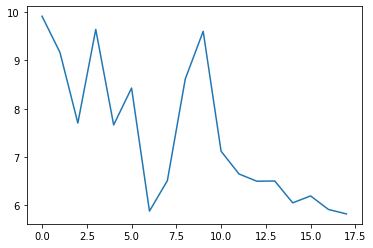

In [92]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses)

In [93]:
def translate(input):
    with torch.no_grad():
        input = normalizeString(input)
        input_tensor = sentenceToTensor(input_lang, input)

        hidden = encoder.initHidden() 

        for word in input_tensor: 
            output, hidden = encoder(word, hidden) 
        
        output_tensors = [] 
        prev_word = torch.tensor([SOS_TOKEN]) 
        for i in range(10): 
            output, hidden = decoder(prev_word, hidden)     
            prev_word = torch.argmax(output[0])
            
            output_tensors.append(output[0]) 
            if prev_word.item() == EOS_TOKEN:
                break
        
        return outputToLang(output_tensors)

translate("Он знает английский")
    

'clearly top land belong . EOS'